In [1]:
# i delete a few healthy image (700)

##### Delete folder before starting

In [2]:
# i asked gpt to write this code

import shutil
import os

def delete_folder(folder_path):
    if os.path.exists(folder_path):
        try:
            shutil.rmtree(folder_path)
            print(f"Folder '{folder_path}' deleted successfully.")
        except OSError as e:
            print(f"Error: {e}")
    else:
        print(f"Folder '{folder_path}' does not exist.")

In [3]:
# train
folder_to_delete = "Apple/train"
delete_folder(folder_to_delete)

# val
folder_to_delete = "Apple/val"
delete_folder(folder_to_delete)

Folder 'Apple/train' deleted successfully.
Folder 'Apple/val' deleted successfully.


# Code

In [4]:
import os 
dir = 'Apple' # this read fodler
print(os.listdir(dir))

['AlternariaBoltch', 'AppleScab', 'BlackRot', 'CedarAppleRust', 'Disease', 'Healthy', 'Rust']


In [5]:
# labels from folder in directory yoooo
labels = os.listdir(dir)
labels.remove("Disease")
labels

['AlternariaBoltch',
 'AppleScab',
 'BlackRot',
 'CedarAppleRust',
 'Healthy',
 'Rust']

In [6]:
# import
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import scipy as sp
import itertools
import zipfile
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D, MaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop

# m8 delete later, should check on it

In [7]:
'''
Abbreviation (so i don't need to write long name)

AlternariaBoltch = boltch
AppleScab = scab
BlackRot = brot
CedarAppleRust = carust
Healthy = healthy
Rust = rust
'''

boltch_dir = os.path.join(dir, 'AlternariaBoltch')
scab_dir = os.path.join(dir, 'AppleScab')
brot_dir = os.path.join(dir, 'BlackRot')
carust_dir = os.path.join(dir, 'CedarAppleRust')
healthy_dir = os.path.join(dir, 'Healthy')
rust_dir = os.path.join(dir, 'Rust')

boltch = os.listdir(boltch_dir)
scab = os.listdir(scab_dir)
brot = os.listdir(brot_dir)
carust = os.listdir(carust_dir)
healthy = os.listdir(healthy_dir)
rust = os.listdir(rust_dir)

In [8]:
import random
import shutil

# Function split
def split_data(src, train_dst, val_dst, split_ratio=0.6):
    files = os.listdir(src)
    random.shuffle(files)

    split_index = int(len(files) * split_ratio)

    train_files = files[:split_index]
    val_files = files[split_index:]

    for file in train_files:
        shutil.copy(os.path.join(src, file), os.path.join(train_dst, file))

    for file in val_files:
        shutil.copy(os.path.join(src, file), os.path.join(val_dst, file))

In [9]:
train_dir = os.path.join(dir, 'train')
val_dir = os.path.join(dir, 'val')

# only use it once
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

os.listdir('Apple/train')
os.listdir('Apple/val')

[]

In [10]:
# only use it once
for i in labels:
    os.makedirs(os.path.join(train_dir, i), exist_ok=True)
    os.makedirs(os.path.join(val_dir, i), exist_ok=True)

In [11]:
# Splitting the data, i hope someone made a better code for this :)
split_data(boltch_dir, os.path.join(train_dir, 'AlternariaBoltch'), os.path.join(val_dir, 'AlternariaBoltch'))
split_data(scab_dir, os.path.join(train_dir, 'AppleScab'), os.path.join(val_dir, 'AppleScab'))
split_data(brot_dir, os.path.join(train_dir, 'BlackRot'), os.path.join(val_dir, 'BlackRot'))
split_data(carust_dir, os.path.join(train_dir, 'CedarAppleRust'), os.path.join(val_dir, 'CedarAppleRust'))
split_data(healthy_dir, os.path.join(train_dir, 'Healthy'), os.path.join(val_dir, 'Healthy'))
split_data(rust_dir, os.path.join(train_dir, 'Rust'), os.path.join(val_dir, 'Rust'))

In [12]:
# ImageDataGenerator
train_gen = ImageDataGenerator(rescale=1.0/256.0, 
                            zoom_range=0.4, 
                            rotation_range=30,
                            horizontal_flip=True, 
                            vertical_flip=True, 
                            shear_range=0.3, 
                            fill_mode='nearest',
                            width_shift_range=0.2, 
                            height_shift_range=0.2, 
                            validation_split=0.2)
val_gen = ImageDataGenerator(rescale=1.0/256.0,
                            validation_split=0.2)

In [13]:
train_dataset = train_gen.flow_from_directory(train_dir, 
                                            target_size=(256, 256), 
                                            color_mode="rgb",
                                            class_mode='categorical', 
                                            batch_size=32)
val_dataset = val_gen.flow_from_directory(val_dir, 
                                        target_size=(256, 256), 
                                        color_mode="rgb",
                                        class_mode='categorical', 
                                        batch_size=32,
                                        subset='validation')

Found 1249 images belonging to 6 classes.


Found 164 images belonging to 6 classes.


In [14]:
print(train_dataset.class_indices)
print(val_dataset.class_indices)

{'AlternariaBoltch': 0, 'AppleScab': 1, 'BlackRot': 2, 'CedarAppleRust': 3, 'Healthy': 4, 'Rust': 5}
{'AlternariaBoltch': 0, 'AppleScab': 1, 'BlackRot': 2, 'CedarAppleRust': 3, 'Healthy': 4, 'Rust': 5}


In [15]:
NUM_TRAIN_DATA = train_dataset.n
NUM_VALID_DATA = val_dataset.n

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, activation='relu', input_shape=(256, 256, 3), padding='same', kernel_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=32, activation='relu', padding='same', kernel_size=(3, 3)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(filters=64, activation='relu', padding='same', kernel_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=64, activation='relu', padding='same', kernel_size=(3, 3)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(filters=128, activation='relu', padding='same', kernel_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=128, activation='relu', padding='same', kernel_size=(3, 3)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(filters=256, activation='relu', padding='same', kernel_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=256, activation='relu', padding='same', kernel_size=(3, 3)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    # Flatten
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=6, activation='softmax'),
])

monitor = EarlyStopping(monitor='val_accuracy',
                        patience=2,
                        verbose=1,
                        mode='max',
                        restore_best_weights=True)

In [17]:
# don't use this one

# model = Sequential()

# model.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=(256, 256, 3)))
# model.add(MaxPool2D(2,2))
# model.add(Dropout(0.25))
# model.add(Conv2D(32, kernel_size=3, activation='relu'))
# model.add(MaxPool2D(2,2))
# model.add(Dropout(0.25))
# model.add(Conv2D(64, kernel_size=3, activation='relu'))
# model.add(MaxPool2D(2,2))
# model.add(Dropout(0.25))
# model.add(Conv2D(128, kernel_size=3, activation='relu'))
# model.add(MaxPool2D(2,2))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dense(7, activation='softmax'))

# model.summary()

In [18]:
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                    

In [23]:
BATCH_SIZE = 32
EPOCHS = 128
# a

In [24]:
history = model.fit(train_dataset, 
                    steps_per_epoch=NUM_TRAIN_DATA//BATCH_SIZE,
                    validation_data=val_dataset,
                    validation_steps=5,
                    epochs=EPOCHS,
                    verbose=1)

Epoch 1/128
39/39 [==============================] - 138s 4s/step - loss: 1.7332 - accuracy: 0.2588 - val_loss: 1.7509 - val_accuracy: 0.1750
Epoch 2/128
39/39 [==============================] - 141s 4s/step - loss: 1.7291 - accuracy: 0.2621 - val_loss: 1.7455 - val_accuracy: 0.2438
Epoch 3/128
39/39 [==============================] - 141s 4s/step - loss: 1.5454 - accuracy: 0.3164 - val_loss: 1.6762 - val_accuracy: 0.2625
Epoch 4/128
39/39 [==============================] - 136s 3s/step - loss: 1.5878 - accuracy: 0.3246 - val_loss: 1.7344 - val_accuracy: 0.2313
Epoch 5/128
39/39 [==============================] - 136s 3s/step - loss: 1.5355 - accuracy: 0.3429 - val_loss: 2.2360 - val_accuracy: 0.2562
Epoch 6/128
39/39 [==============================] - 140s 4s/step - loss: 1.5510 - accuracy: 0.3599 - val_loss: 1.7013 - val_accuracy: 0.4313
Epoch 7/128
39/39 [==============================] - 138s 3s/step - loss: 1.4088 - accuracy: 0.4059 - val_loss: 1.3564 - val_accuracy: 0.4625
Epoch 

6/6 [==============================] - 4s 570ms/step


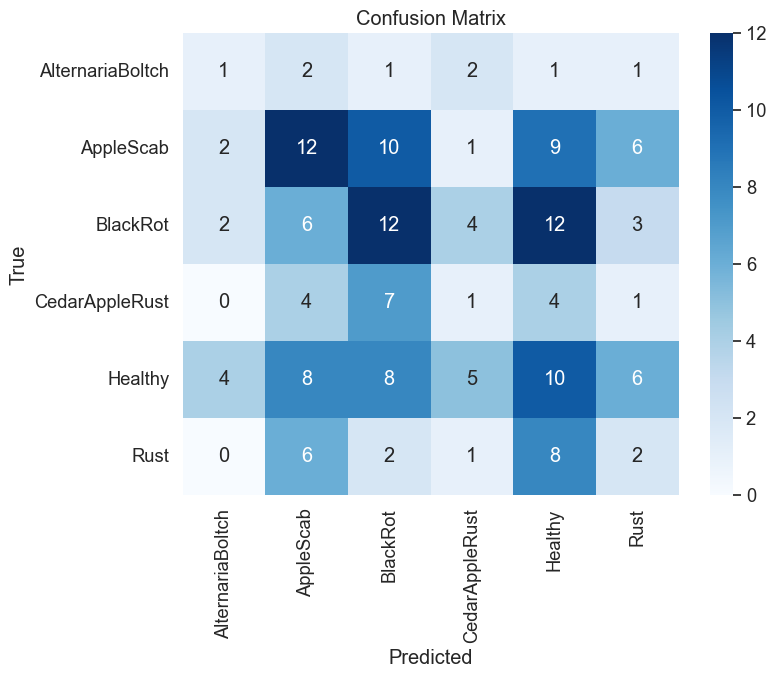

In [25]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

predictions = model.predict(val_dataset, steps=len(val_dataset))
predicted_labels = np.argmax(predictions, axis=1)
true_labels = val_dataset.classes
cm = confusion_matrix(true_labels, predicted_labels)

# Create a seaborn heatmap
sns.set(font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [26]:
model.save('attempt_005.h5')

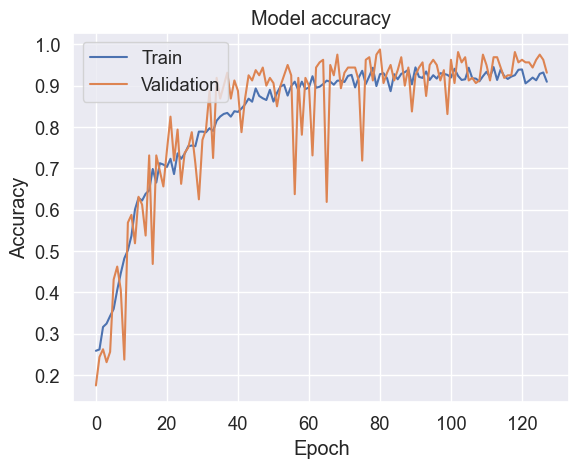

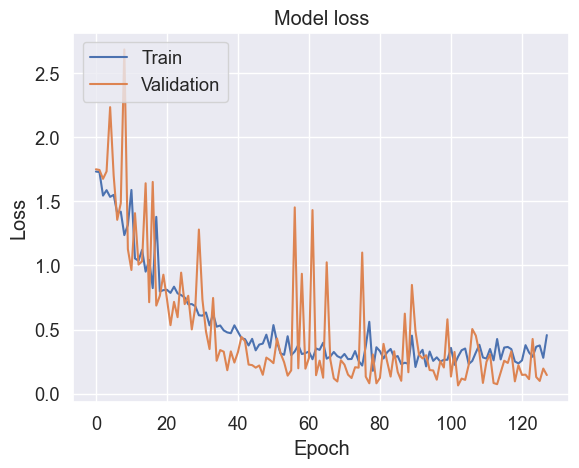

In [27]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# i think 60 epochs is enough